In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/spiking.jl")
include("src/vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
using Plots

In [4]:
n_x = 1
n_y = 10
n_vsa = 512

512

In [5]:
repeats = 6

6

In [6]:
phase_x = random_symbols((n_vsa, 1));

In [7]:
phase_z = random_symbols((n_vsa, 3));

In [8]:
phase_xp = random_symbols((n_vsa, 1));

In [9]:
phase_y = reduce(hcat, collect(range(start=phase_x, stop=phase_xp, length=n_y)));

In [10]:
sims = similarity(phase_x, phase_y)

1×10 Matrix{Float64}:
 1.0  0.957139  0.836721  0.661175  …  0.00697343  -0.0478505  -0.0595813

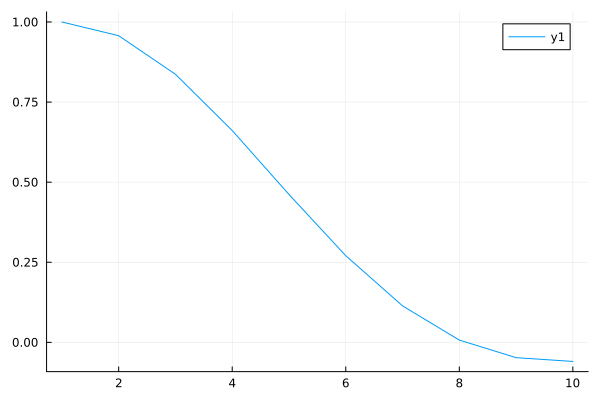

In [11]:
plot(sims |> vec)

In [12]:
similarity_self(phase_z, 2)

3×3 Matrix{Vector{Float64}}:
 [1.0]        [0.0388086]   [-0.034117]
 [0.0388086]  [1.0]         [0.00387105]
 [-0.034117]  [0.00387105]  [1.0]

In [13]:
spk_args = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [14]:
st_x = phase_to_train(phase_x, spk_args, repeats = repeats)
st_y = phase_to_train(phase_y, spk_args, repeats = repeats)

Spike Train: (512, 10) with 30720 spikes.

In [15]:
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [16]:
using OrdinaryDiffEq

In [17]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [49]:
function similarity(x::SpikeTrain, y::SpikeTrain, dim::Int = 1; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args(), return_solution::Bool = false)
    sol_x = phase_memory(x, tspan = tspan, spk_args = spk_args)
    sol_y = phase_memory(y, tspan = tspan, spk_args = spk_args)

    
    u_x = normalize_potential.(Array(sol_x))
    u_y = normalize_potential.(Array(sol_y))

    interference = u_x .+ u_y
    magnitude = clamp.(abs.(interference), 0.0, 2.0)
    half_angle = acos.(0.5 .* magnitude)
    sim = cos.(2.0 .* half_angle)
    avg_sim = mean(sim, dims=dim)
    
    return avg_sim

end

similarity (generic function with 3 methods)

In [50]:
sim = similarity(st_x, st_y, 1, tspan=tspan, spk_args=sa, return_solution=true);

In [54]:
sim

1×10×601 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

[:, :, 2] =
 -0.945312  -0.98047  -0.983398  …  -0.983398  -0.981445  -0.969728

[:, :, 3] =
 -0.917969  -0.970707  -0.973637  …  -0.97461  -0.972657  -0.958986

;;; … 

[:, :, 599] =
 1.0  0.956475  0.83703  0.660518  …  0.00632217  -0.0475157  -0.0591233

[:, :, 600] =
 1.0  0.956463  0.837005  0.660479  …  0.00626244  -0.0475719  -0.0591706

[:, :, 601] =
 1.0  0.956444  0.836973  0.660441  …  0.00626083  -0.0475663  -0.0591313

In [51]:
sim |> size

(1, 10, 601)

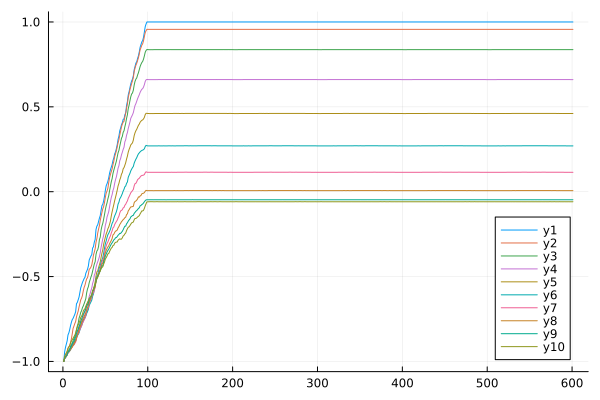

In [52]:
plot(sim[1,:,:]')

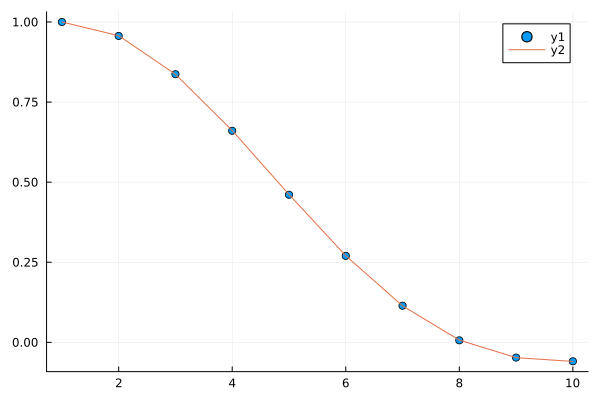

In [55]:
scatter(sim[1,:,end])
plot!(sims |> vec)

In [47]:
spk_sim = sim[1,:,end]

10-element Vector{Float64}:
  0.9999999622814364
  0.9564444548635167
  0.8369732433015685
  0.6604409135557033
  0.4606785396838056
  0.26993904619872156
  0.1143559615349927
  0.006260834540405931
 -0.04756626304349304
 -0.059131297015353246

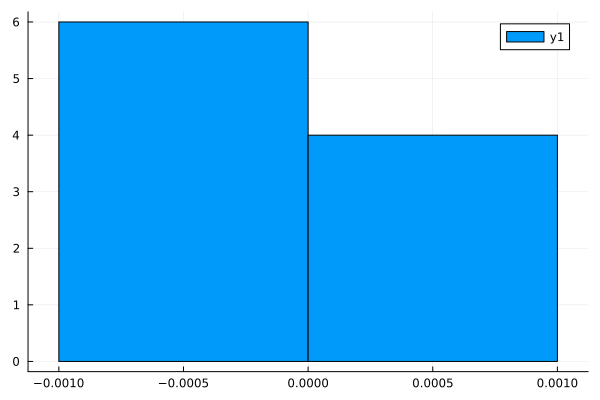

In [48]:
error = spk_sim .- vec(sims)
histogram(error)